In [1]:
# @title Library Installation
# The installation is performed in a single block for optimization.

print("Updating pip...")
!pip install --upgrade pip

# --- Uninstallation to ensure a clean install of specific versions ---
print("Uninstalling PyTorch, Flash-Attention, and BitsAndBytes for a clean installation...")
!pip uninstall -y torch torchvision torchaudio flash-attn bitsandbytes transformers accelerate peft sentence-transformers

# --- Crucial step: Install PyTorch 2.4.1 for CUDA 12.4 ---
# The torch index URL for CUDA 12.4 is https://download.pytorch.org/whl/cu124
# We are forcing version 2.4.1 to match your Windows configuration.
CUDA_VERSION_FOR_TORCH = "cu124"
TORCH_INDEX_URL = f"https://download.pytorch.org/whl/{CUDA_VERSION_FOR_TORCH}"

print(f"Installing torch==2.4.1 and CUDA dependencies for {CUDA_VERSION_FOR_TORCH}...")
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url {TORCH_INDEX_URL}

# --- Install Hugging Face Transformers and Accelerate ---
# These are key dependencies for many models and must be installed after PyTorch
# to ensure the correct versions are linked.
print("Installing Hugging Face Transformers and Accelerate...")
!pip install transformers accelerate

# --- Install Flash Attention 2.6.3 and BitsAndBytes ---
print("Installing flash-attn==2.6.3 and bitsandbytes...")
!pip install flash-attn==2.6.3 --no-build-isolation
!pip install bitsandbytes --upgrade

# --- Install other necessary libraries, including those that caused the error ---
# Installing these after their dependencies (transformers, accelerate),
# ensures that `pip` finds the required packages.
print("Installing other necessary libraries...")
!pip install peft sentence-transformers
!pip install pandas numpy matplotlib seaborn scikit-learn google-generativeai pillow requests anthropic tensorflow qwen-vl-utils

print("\nInstallation completed. Check the messages to confirm there are no errors.")


Updating pip...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Uninstalling PyTorch, Flash-Attention, and BitsAndBytes for a clean installation...
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.56.1
Uninstalling transformers-4.56.1:
  Successfully uninstalled transformers-4.56.1
Found existing installation: accelerate 1.10.1
Uninstalling accelerate-1.10.1:
  Successfully uninstalled accelerate-1.10.1
Found existing ins

In [2]:
# @title Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline

from PIL import Image

import requests
from io import BytesIO
import base64
import os
import torch
import anthropic

from qwen_vl_utils import process_vision_info

from huggingface_hub import login
from google.colab import userdata
import google.generativeai as genai

import re
from datetime import datetime
import sys
import xml.etree.ElementTree as ET
import time
import json
from functools import partial
import traceback

print("Imports completed.")

Imports completed.


In [3]:
import transformers
print(transformers.__version__)

4.56.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df = pd.read_csv(path, encoding='utf-8')

print(df.head())

                                                 url  \
0  http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3...   
1  http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bj...   
2  http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgq...   
3              http://01anjali2001.github.io/netflix   
4  http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj...   

                                        html_content  \
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...   
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...   
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...   
3      0004_01anjali2001.github.io_netflix/page.html   
4  0005_bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a...   

                                          screenshot  label  
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...      1  
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...      1  
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...      1  
3  0004_01anjali2001.github.io_netflix/screenshot...      1  
4  0005_bafybeid

In [7]:
df.dropna(inplace=True)

print(df.info())

print(df.describe())

print(df.isnull().sum())

if 'label' in df.columns:
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1000 non-null   object
 1   html_content  1000 non-null   object
 2   screenshot    1000 non-null   object
 3   label         1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
           label
count  1000.0000
mean      0.8000
std       0.4002
min       0.0000
25%       1.0000
50%       1.0000
75%       1.0000
max       1.0000
url             0
html_content    0
screenshot      0
label           0
dtype: int64
label
1    800
0    200
Name: count, dtype: int64


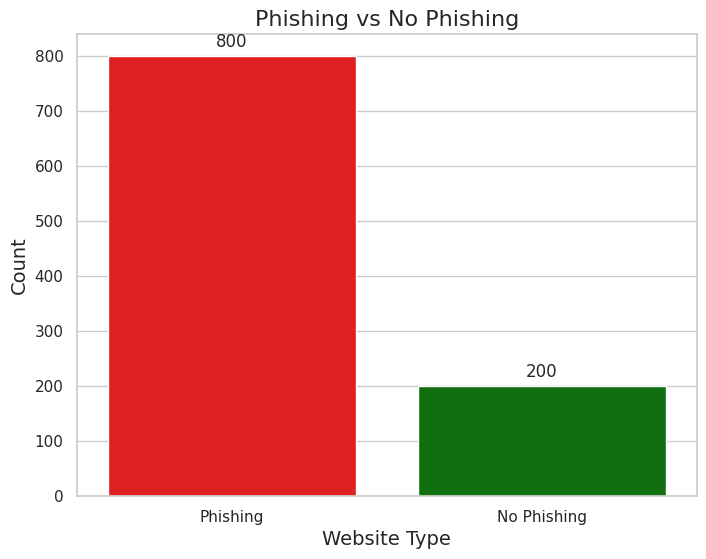

In [8]:
# Map numerical labels to descriptive names
label_map = {0: 'No Phishing', 1: 'Phishing'}
df['label_name'] = df['label'].map(label_map)

# Set the style of the plot
sns.set(style="whitegrid")

# Create the figure and axes for the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label_name', data=df, hue='label_name', palette={'No Phishing': 'green', 'Phishing': 'red'}, legend=False)

# Set the title and labels for the axes
plt.title('Phishing vs No Phishing', fontsize=16)
plt.xlabel('Website Type', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add value annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

# Display the plot
plt.show()

In [9]:
MODELOS_OPEN_SOURCE = {
    'Qwen/Qwen2-VL-2B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'Qwen/Qwen2.5-VL-3B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'Qwen/Qwen2-VL-7B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'Qwen/Qwen2.5-VL-7B-Instruct': {
        'type': 'qwen',
        'max_tokens': 8000,
    },
    'llava-hf/llava-1.5-7b-hf': {
        'type': 'llava',
        'max_tokens': 8000,
    },
    'llava-hf/llama3-llava-next-8b-hf': {
        'type': 'llava',
        'max_tokens': 8000,
        'device': 0,
    },
    'context-labs/meta-llama-Llama-3.2-11B-Vision-Instruct-FP16': {
        'type': 'context-labs',
        'max_tokens': 8000,
    },
    'microsoft/Phi-3.5-vision-instruct': {
        'type': 'phi',
        'max_tokens': 8000,
    },
    'ByteDance-Seed/UI-TARS-1.5-7B': {
        'type': 'ByteDance',
        'max_tokens': 50,
    },

}

In [10]:
def _configure_pipeline(model_id: str, models_config: dict):
    """
    Configures and loads the Hugging Face pipeline.
    It also checks if the tokenizer has a configured chat template.

    Args:
        model_id (str): The identifier of the model to load.
        models_config (dict): A dictionary containing configurations for different models.

    Returns:
        tuple: A tuple containing the loaded pipeline, the model configuration, and the pad token ID.

    Raises:
        ValueError: If the model_id is not found in the configuration dictionary.
        Exception: If an error occurs while loading the pipeline.
    """
    print(f"⚡ Configuring and loading pipeline for {model_id}...")
    if model_id not in models_config:
        raise ValueError(f"Configuration not found for the model: {model_id}")
    config = models_config[model_id]

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    torch_dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
    print(f"Using torch_dtype: {torch_dtype}")

    try:
        pipe = pipeline(
            "image-text-to-text",
            model=model_id,
            model_kwargs={"torch_dtype": torch_dtype},
            device_map="auto",
            trust_remote_code=True
        )

        # --- Chat template verification ---
        if hasattr(pipe.tokenizer, 'chat_template') and pipe.tokenizer.chat_template is not None:
            print("✅ Tokenizer has a chat template configured.")
        else:
            print("⚠️ Tokenizer does NOT have a chat template configured.")
            print("Manual prompt construction will be used in _generate_response if apply_chat_template fails.")

        pad_token_id = pipe.tokenizer.pad_token_id
        if pad_token_id is None:
            pad_token_id = pipe.tokenizer.eos_token_id

        if pad_token_id is None:
            print("⚠️ Warning: Could not get pad_token_id or eos_token_id from the tokenizer.")

        print(f"✅ Pipeline '{model_id}' loaded successfully.")
        return pipe, config, pad_token_id

    except Exception as e:
        print(f"❌ Error loading the pipeline for {model_id}: {e}")
        raise # Re-raise the exception

In [11]:
def _load_row_data(row: pd.Series, base_path: str):
    """
    Loads HTML content and a screenshot image from a single row of a DataFrame.

    Args:
        row (pd.Series): A row containing file paths for 'html_content' and 'screenshot'.
        base_path (str): The base directory where the files are stored.

    Returns:
        tuple: A tuple containing the HTML content (str) and the prepared screenshot (PIL.Image).

    Raises:
        ValueError: If the screenshot image cannot be loaded.
    """
    html_path = os.path.join(base_path, row['html_content'])
    screenshot_path = os.path.join(base_path, row['screenshot'])

    # Read HTML
    with open(html_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Load and prepare the image
    screenshot = Image.open(screenshot_path).convert('RGB')
    if screenshot is None:
        raise ValueError(f"Could not load the image: {screenshot_path}")

    # Resize
    screenshot = screenshot.resize((512, 512))

    return html_content, screenshot

In [12]:
def prompt_option1_html(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive HTML content.
                    Based on the HTML analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"HTML: {html_content[:5000]}"
                )}
            ]
        }
    ]
    return prompt

In [13]:
def prompt_option2_html(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive HTML content.
                    Consider the following aspects of the HTML:
                        1. Suspicious form fields (password/credit card inputs)
                        2. Poor design quality or imitation of legitimate brands
                        3. Urgency-creating language or threats
                        4. Mismatched links (href vs displayed text)
                        5. Lack of legitimate contact information
                        6. Suspicious scripts or iframes

                    Based on this analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"HTML: {html_content[:5000]}"
                )}
            ]
        }
    ]
    return prompt


In [14]:
def prompt_option3_html(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    [Context] You are a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive HTML content.
                    Follow this process to analyze the HTML:

                        HTML Analysis:
                            1. Examine the forms for sensitive data collection
                            2. Check for brand impersonation in logos/text
                            3. Analyze the quality of content and design
                            4. Verify link consistency (displayed vs actual URLs)
                            5. Look for suspicious scripts or external resources
                            6. Check for presence/absence of security indicators

                        Conclusion:
                            Based on the HTML analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"HTML: {html_content[:5000]}"
                )}
            ]
        }
    ]
    return prompt

In [15]:
def _generate_response(pipe, messages: list, config: dict, pad_token_id: int):
    """
    Generates the model's response using the pipeline.
    Attempts to use apply_chat_template if available, otherwise uses a manual fallback.
    """
    formatted_prompt_string = None

    # Try to use the tokenizer's built-in chat template
    if hasattr(pipe.tokenizer, 'chat_template') and pipe.tokenizer.chat_template is not None:
        try:
            formatted_prompt_string = pipe.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
        except Exception as e:
            print(f"❌ Error applying chat template: {e}")
            formatted_prompt_string = None

    # If the chat template is not available or failed, build the prompt manually
    if formatted_prompt_string is None:
        print("apply_chat_template not available or failed. Building prompt manually...")
        try:
            user_content = ""
            for msg in reversed(messages):
                if msg.get('role') == 'user' and msg.get('content'):
                    if isinstance(msg['content'], list):
                        user_content_parts = []
                        for part in msg['content']:
                            if part.get('type') == 'text' and part.get('text'):
                                user_content_parts.append(part['text'])
                        user_content = " ".join(user_content_parts)
                    else:
                        user_content = msg['content']
                    break

            if not user_content:
                for msg in reversed(messages):
                    if msg.get('role') == 'system' and msg.get('content'):
                        user_content = msg['content']
                        print("Using content from 'system' message as prompt.")
                        break

            if not user_content:
                raise ValueError("No user or system content found in messages to build a manual prompt.")

            formatted_prompt_string = f"A chat between a curious user and an AI assistant.\nUSER:\n{user_content}\nASSISTANT:"

        except Exception as e:
            print(f"❌ Error building prompt manually (fallback): {e}")
            return "Error: Failed to build prompt (fallback)"

    # Configure generation arguments
    generate_kwargs = {
        "do_sample": config.get("do_sample", False),
        "temperature": config.get("temperature", 0.7 if config.get("do_sample", False) else 1.0),
        "top_p": config.get("top_p", 0.9 if config.get("do_sample", False) else 1.0),
        "max_new_tokens": config.get('max_tokens', 50),
        "return_full_text": False,
    }

    # Remove sampling parameters if do_sample is false
    if not generate_kwargs.get("do_sample", False):
        generate_kwargs.pop("temperature", None)
        generate_kwargs.pop("top_p", None)

    try:
        # Generate the output using the pipeline
        outputs = pipe(
            formatted_prompt_string,
            **generate_kwargs
        )
    except Exception as e:
        print(f"❌ Error during pipeline generation: {e}")
        print(f"Formatted prompt that caused the error: '{formatted_prompt_string}'")
        return "Error: Pipeline generation failed"

    # Process and clean the generated output
    if outputs and isinstance(outputs, list) and len(outputs) > 0 and 'generated_text' in outputs[0]:
        response = outputs[0]['generated_text'].strip()

        # Clean up common prefixes and suffixes
        if response.startswith("ASSISTANT:"):
            response = response[len("ASSISTANT:"):].strip()
        if response.startswith("ANSWER:"):
            response = response[len("ANSWER:"):].strip()
        if response.endswith("<|im_end|>"):
            response = response[:-len("<|im_end|>")].strip()

        # Extract the final classification
        final_classification = "UNKNOWN"
        match = re.search(r'\b(PHISHING|SAFE|LEGITIMATE)\b', response, re.IGNORECASE)
        if match:
            matched_text = match.group(1).lower()
            if "phishing" in matched_text:
                final_classification = "Phishing"
            elif "safe" in matched_text or "legitimate" in matched_text:
                final_classification = "Legitimate"
        else:
            first_word_or_line = response.split('\n')[0].strip().split(' ')[0].strip()
            if "phishing" in first_word_or_line.lower():
                final_classification = "Phishing"
            elif "safe" in first_word_or_line.lower() or "legitimate" in first_word_or_line.lower():
                final_classification = "Legitimate"
            else:
                print(f"⚠️ 'PHISHING' or 'SAFE'/'LEGITIMATE' not found in the response. Returning the first part: '{response[:50]}...'")
                final_classification = response.split('\n')[0].strip()

        return final_classification
    else:
        print(f"⚠️ Unexpected pipeline output: {outputs}")
        return "Error: Unexpected pipeline output format"

In [16]:
def _process_generated_text(generated_text: str):
    """
    Processes the raw text output from the model.

    Args:
        generated_text (str): The raw text string generated by the model.

    Returns:
        str: The processed text string, with leading/trailing whitespace removed.

    Raises:
        TypeError: If the input is not a string.
    """
    if not isinstance(generated_text, str):
        raise TypeError(f"Unexpected output format: expected str, received {type(generated_text)}")

    return generated_text.strip()

In [17]:
def _process_row(row: pd.Series, pipe, config: dict, pad_token_id: int, base_path: str, output_filepath: str, prompt_method_to_use):
    """
    Processes a single row from the DataFrame: loads data, builds the prompt, and generates a response.

    Args:
        row (pd.Series): The row of the DataFrame to process.
        pipe: The loaded Hugging Face pipeline.
        config (dict): The configuration dictionary for the model.
        pad_token_id (int): The pad token ID for the tokenizer.
        base_path (str): The base directory for data files.
        output_filepath (str): The path to the output log file.
        prompt_method_to_use: The function to use for building the prompt.

    Returns:
        str: The processed text response from the model, or an error message.
    """
    url = row.get('url', 'URL unknown')
    label = row.get('label', 'Label unknown')
    label_text = "PHISHING (true)" if label == 1 else "SAFE (false)"
    try:
        # Load the data for the current row
        html_content, screenshot = _load_row_data(row, base_path)

        # Build the prompt using the specified method
        messages = prompt_method_to_use(html_content, screenshot, url)

        # Generate the response from the model
        generated_text = _generate_response(pipe, messages, config, pad_token_id)

        # Process and clean the generated text
        format_text = _process_generated_text(generated_text)

        # Log the full output to the console
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"--- FULL Output for URL: {url} {label_text} ({timestamp}) ---")
        print(format_text)
        print(f"--- End of Full Output ---")

        # Append the results to the output file
        try:
            with open(output_filepath, 'a', encoding='utf-8') as f:
                f.write(f"URL: {url}\n")
                f.write(f"\nExpected Result: {label_text}\n")
                f.write(f"Output: {format_text}\n\n")
        except IOError as e:
            print(f"❌ Error writing to file {output_filepath} for {url}: {e}")

        # Return the processed output text
        return format_text

    except FileNotFoundError as e:
        print(f"❌ Error - File not found for {url}: {e}")
        return f"Error: File not found ({e.filename})"
    except ValueError as e:
        print(f"❌ Error - Invalid value (e.g., image loading) for {url}: {e}")
        return f"Error: {e}"
    except Exception as e:
        # Handle any other unexpected errors during row processing
        print(f"❌ Unexpected error processing {url}: {type(e).__name__} - {e}")
        return "Analysis Error"

In [18]:
def classifier(model_id: str, df: pd.DataFrame, base_path: str, models_config: dict, output_filepath: str, prompt_method_to_use):
    """
    Main function to classify a DataFrame using a specified model and prompting method.

    Args:
        model_id (str): The identifier for the model to use.
        df (pd.DataFrame): The DataFrame containing the data to classify.
        base_path (str): The base directory for data files.
        models_config (dict): A dictionary with model configurations.
        output_filepath (str): The path to the output log file.
        prompt_method_to_use: The function to use for building the prompt.

    Returns:
        pd.DataFrame: The original DataFrame with a new 'prediction' column.
    """
    pipe = None
    config = None
    pad_token_id = None

    try:
        # 1. Configure and load the pipeline
        pipe, config, pad_token_id = _configure_pipeline(model_id, models_config)

        # 2. Create a partial function to pass fixed arguments to the processing function
        process_row_with_context = partial(
            _process_row,
            pipe=pipe,
            config=config,
            pad_token_id=pad_token_id,
            base_path=base_path,
            output_filepath=output_filepath,
            prompt_method_to_use=prompt_method_to_use
        )

        # 3. Apply the processing function to the entire DataFrame
        print(f"🚀 Processing {len(df)} rows...")
        df['prediction'] = df.apply(process_row_with_context, axis=1)
        print("✅ Processing completed.")
        return df

    except ValueError as e:
        # Handle errors during pipeline configuration
        print(f"❌ Critical Error - Configuration failed: {e}", file=sys.stderr)
        traceback.print_exc()
        return df
    except Exception as e:
        # Handle other unexpected errors (e.g., CUDA memory error when loading the model)
        print(f"❌ Unexpected Critical Error: {type(e).__name__} - {e}", file=sys.stderr)
        traceback.print_exc()
        return df
    finally:
        # Release memory in a final block to ensure it always runs
        if pipe is not None:
            print(f"🧹 Releasing pipeline '{model_id}'...")
            try:
                # Attempt to move the model to CPU and delete it
                if hasattr(pipe, 'model') and hasattr(pipe.model, 'cpu'):
                    pipe.model.cpu()
                del pipe.model
            except Exception as del_e:
                print(f"ⓘ Could not move model to CPU or delete explicitly: {del_e}")
            del pipe
            print("✅ Pipeline released.")
        else:
            print("ⓘ No pipeline was loaded to release.")

        # Clear CUDA cache to free up GPU memory
        print("🗑️ Clearing CUDA cache...")
        torch.cuda.empty_cache()
        print("✅ CUDA cache cleared.")

In [19]:
models_to_test = [
    'Qwen/Qwen2-VL-2B-Instruct',
    'Qwen/Qwen2.5-VL-3B-Instruct',
    'Qwen/Qwen2-VL-7B-Instruct',
    'Qwen/Qwen2.5-VL-7B-Instruct',
    'llava-hf/llava-1.5-7b-hf',
    'llava-hf/llama3-llava-next-8b-hf',
    'ByteDance-Seed/UI-TARS-1.5-7B',
    'context-labs/meta-llama-Llama-3.2-11B-Vision-Instruct-FP16',
    'microsoft/Phi-3.5-vision-instruct'
]

prompt_methods = [
    prompt_option1_html,
    prompt_option2_html,
    prompt_option3_html
]

# Paths and data
files_path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1'
files_path = os.path.join(files_path, '')
csv_path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df_data = pd.read_csv(csv_path, encoding='utf-8')
output_directory_path = '/content/drive/MyDrive/Colab Notebooks'

for selected_model in models_to_test:
    print(f"\n===== Processing Model: {selected_model} =====")
    base_filename = selected_model.split('/')[-1]

    # Inner loop: Iterate over each prompt method
    for i, prompt_method in enumerate(prompt_methods):
        method_name = prompt_method.__name__

        # Generate a unique filename for each model and method combination
        output_filename = f"{base_filename}_{method_name}_results.txt"
        final_output_filepath = os.path.join(output_directory_path, output_filename)

        print(f"  --- Executing with method: {method_name} ---")
        print(f"  Saving results to: {final_output_filepath}")

        # Call the classifier function with the new filename
        # and pass the prompt method to be used internally
        df_result = classifier(
            model_id=selected_model,
            df=df_data,
            base_path=files_path,
            models_config=MODELOS_OPEN_SOURCE,
            output_filepath=final_output_filepath,
            prompt_method_to_use=prompt_method
        )
        print("--------------------------------------------------")


===== Processing Model: Qwen/Qwen2-VL-2B-Instruct =====
  --- Executing with method: prompt_option1_html ---
  Saving results to: /content/drive/MyDrive/Colab Notebooks/Qwen2-VL-2B-Instruct_prompt_option1_html_results.txt
⚡ Configuring and loading pipeline for Qwen/Qwen2-VL-2B-Instruct...
Using torch_dtype: torch.bfloat16


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✅ Tokenizer has a chat template configured.
✅ Pipeline 'Qwen/Qwen2-VL-2B-Instruct' loaded successfully.
🚀 Processing 1000 rows...


Keyword argument `do_sample` is not a valid argument for this processor and will be ignored.


--- FULL Output for URL: http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3tdzhjzj7zjx4jbffigie.ipfs.infura-ipfs.io PHISHING (true) (2025-09-21 12:06:50) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpdr43cfon6oddmha6lue.ipfs.dweb.link PHISHING (true) (2025-09-21 12:06:52) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtuyzw54fpqryvosoumvu.ipfs.dweb.link PHISHING (true) (2025-09-21 12:06:54) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://01anjali2001.github.io/netflix PHISHING (true) (2025-09-21 12:06:57) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a5fovzmg52vaa2wcggu.ipfs.dweb.link PHISHING (true) (2025-09-21 12:07:01) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeidmsq7bsjz7mqcekzwnicnbh2b2bptwpbvqftmwtajg32kmjk7kzy.ipfs.dweb.link PHISHIN

KeyboardInterrupt: 